# Using Machine Learning to Identify Alzheimer's Disease in the Initial Stages

##### Model Development

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import models
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function for augmenting images for dataset diversity
def custom_image_preprocess(image):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(factor=(-0.2, 0.3)),
        tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])
    
    return data_augmentation(image)

In [3]:
# Image processing constants
BATCH_SIZE = 16
IMG_HEIGHT = 72
IMG_WIDTH = 72
IMG_CHANNELS = 3

# Directory paths for training and test datasets
train_dir = "/Users/adity/Downloads/Alzheimers_Proj/dataset/Alzheimer_sDataset/train"
test_dir = "/Users/adity/Downloads/Alzheimers_Proj/dataset/Alzheimer_sDataset/test"


# Seeds give consistent results
seed_1 = tf.random.set_seed(1234)
seed_2 = tf.random.set_seed(1235)   

In [4]:
# Image Generators, data augmentation, and preprocessing functions
train_image_generator = ImageDataGenerator(rescale=1. / 255, vertical_flip=True, horizontal_flip=True, preprocessing_function=custom_image_preprocess,) 
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    color_mode='rgb',
    seed=seed_1,)
    
test_image_generator = ImageDataGenerator(rescale=1. / 255, vertical_flip=True, horizontal_flip=True, preprocessing_function=custom_image_preprocess,)
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
    directory=test_dir,
    shuffle=False,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    color_mode='rgb',
    seed=seed_2,)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [5]:
# Get class names from training dataset folder
class_names = [name for name in os.listdir(train_data_gen.directory) if os.path.isdir(os.path.join(train_data_gen.directory, name))]
print(class_names)

# Count the number of classes in training dataset folder
num_classes = len(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [6]:
# Define the baseline model architecture
def baseline_model(num_classes):
    model = Sequential([
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callback for adjusting learning rate
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
# Compile the model
model = baseline_model(num_classes)
opt = SGD(learning_rate=0.01)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=tf.keras.metrics.BinaryAccuracy())

In [10]:
# Train the model. About 30 min/epoch.
epochs = 2 # change to larger values for higher accuracy
history = model.fit(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/2


c:\Users\adity\anaconda3\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


321/321 [==============================] - 2396s 7s/step - loss: 0.4554 - binary_accuracy: 0.7580 - val_loss: 0.4345 - val_binary_accuracy: 0.7643 - lr: 0.0010
Epoch 2/2
321/321 [==============================] - 2990s 9s/step - loss: 0.4314 - binary_accuracy: 0.7774 - val_loss: 0.4649 - val_binary_accuracy: 0.7674 - lr: 0.0010


##### The model will be fitted with data, and then saved successfully

In [11]:
#save the model
model.save('/mnt/data/prediction_model') 

INFO:tensorflow:Assets written to: /mnt/data/prediction_model\assets


INFO:tensorflow:Assets written to: /mnt/data/prediction_model\assets


#### Results and Visualizations

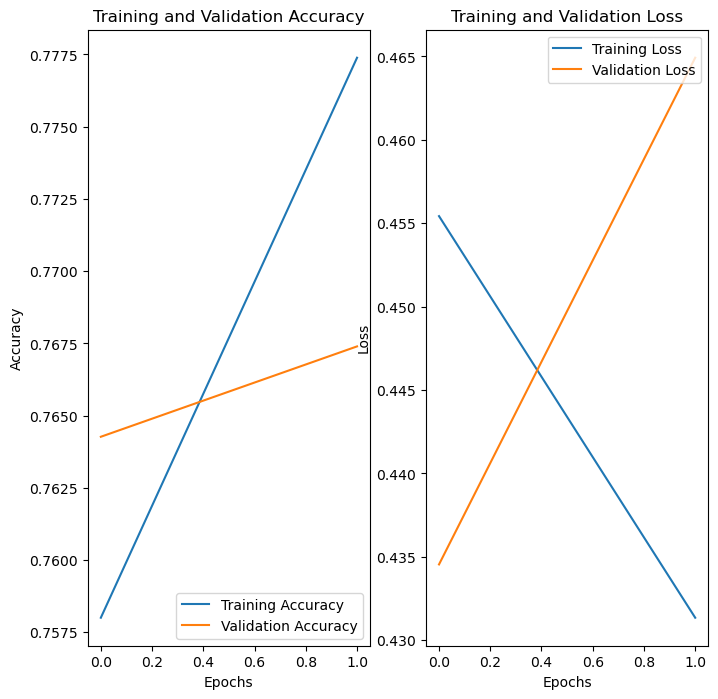

In [12]:
# Store accuracy and loss data from the training
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plotting accuracy and loss data with MatPlotLib using data from the training process
plt.figure(figsize=(8, 8))

# Plot for Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')  # X-axis label for epochs
plt.ylabel('Accuracy')  # Y-axis label for accuracy

# Plot for Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  # X-axis label for epochs
plt.ylabel('Loss')  # Y-axis label for loss

plt.show()


1/1 [==============================] - 0s 88ms/step


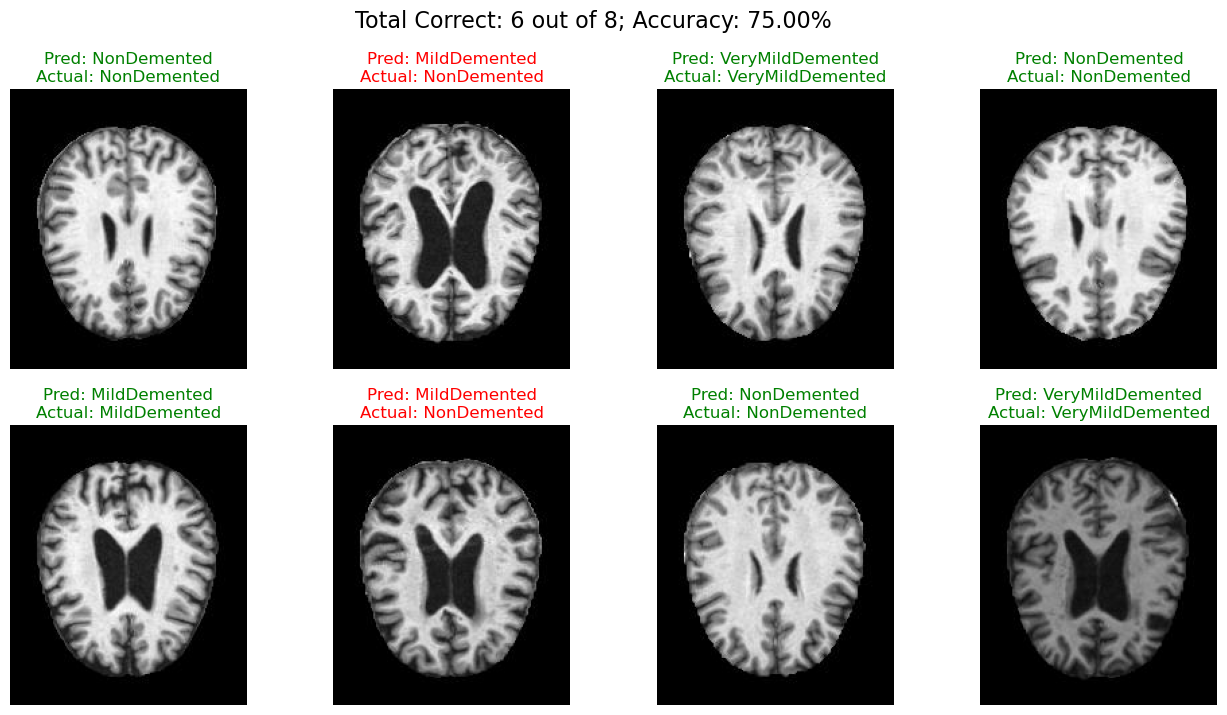

In [196]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Load the model, previously saved
model = tf.keras.models.load_model('/mnt/data/my_model')

# Redfine test directory for reference
test_dir = "/Users/adity/Downloads/Alzheimers_Proj/dataset/Alzheimer_sDataset/test"

# Function to preprocess images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Preprocess the image to fit the ResNet50 model (50-layer CNN) requirements
    return tf.keras.applications.resnet50.preprocess_input(img_array)

# Store all image paths from the test directory in a list
image_paths = []
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        image_paths += [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]

# Select 8 random images from test directory
random_images = random.sample(image_paths, 8)

# Predict and plot
plt.figure(figsize=(16, 8))
correct_count = 0

for i, img_path in enumerate(random_images):
    img = preprocess_image(img_path)
    prediction = model.predict(img)
    
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]
    
    actual_class = os.path.basename(os.path.dirname(img_path))

    # Check if prediction is correct
    is_correct = predicted_class == actual_class
    if is_correct:
        correct_count += 1
        color = 'green'
    else:
        color = 'red'

    # Plotting horizontally
    plt.subplot(2, 4, i+1)
    plt.imshow(image.load_img(img_path))
    plt.title(f'Pred: {predicted_class}\nActual: {actual_class}', color=color)
    plt.axis('off')

# Display results at the header
plt.suptitle(f"Total Correct: {correct_count} out of 8; Accuracy: {correct_count/8:.2%}", fontsize=16)
plt.show()
